# SFS Performance Across High Dimensions

This notebook contains the reproducible code for generating Figure 5(b), which demonstrates the scalability of SFS across dimensions ranging from 10 to 1,000 in high-dimensional Gaussian mixtures.

## Key Features:
- Implements SFS for Gaussian mixtures with varying dimensions (10 to 1,000)
- Calculates proportion errors and computational time for each dimension
- Generates a dual-panel plot showing:
  1. Mean proportion error with error bars
  2. Computational time across dimensions

The code showcases SFS's ability to maintain low proportion errors and linear time scaling even in very high dimensions, with computation time under one minute for 1,000 dimensions.

In [1]:
import torch
import numpy as np
import time
import pandas as pd
from func import SFS_gauss
import matplotlib.pyplot as plt
from utils import generate_circle_alpha, proportions_error, kmeans_plot

# Parameters
N = 5000
kap = 8
K = 100
B = 5000  # Batch size
ps = [10,  100,  300,  500,  700,  900, 1000]  # Different values of p to simulate
device = 'cuda' if torch.cuda.is_available() else 'cpu'
results = []

# Ensure output directory exists
import os
output_dir = 'results'
os.makedirs(output_dir, exist_ok=True)

# Loop over each p value
for p in ps:
    rad = 2.0
    alpha = generate_circle_alpha(kap, p) * rad
    sigma = [0.03 * np.eye(p) for _ in range(kap)]
    theta = np.array([1 / kap] * kap)
    
    start_time = time.time()
    res = SFS_gauss(N, p, kap, K, alpha, sigma, theta, B, parallel=False, device=device)
    end_time = time.time()
    
    # Save the data
    file_path = os.path.join(output_dir, f'sfs_p{p}.csv')
    pd.DataFrame(res).to_csv(file_path, index=False)
    
    # Calculate proportions and errors
    estimated_theta, error = proportions_error(res, theta)
    duration = end_time - start_time
    print(f"p={p}: All done in {duration:.2f} seconds")
    # Record results
    results.append((p, duration, error))

# Optionally save the summary results to a CSV
summary_df = pd.DataFrame(results, columns=['Dimension p', 'Time (seconds)', 'Proportion Error'])
summary_df.to_csv(os.path.join(output_dir, 'summary_results.csv'), index=False)

p=10: All done in 4.96 seconds
p=100: All done in 5.76 seconds
p=300: All done in 26.07 seconds
p=500: All done in 38.85 seconds
p=700: All done in 92.05 seconds
p=900: All done in 155.63 seconds
p=1000: All done in 189.14 seconds


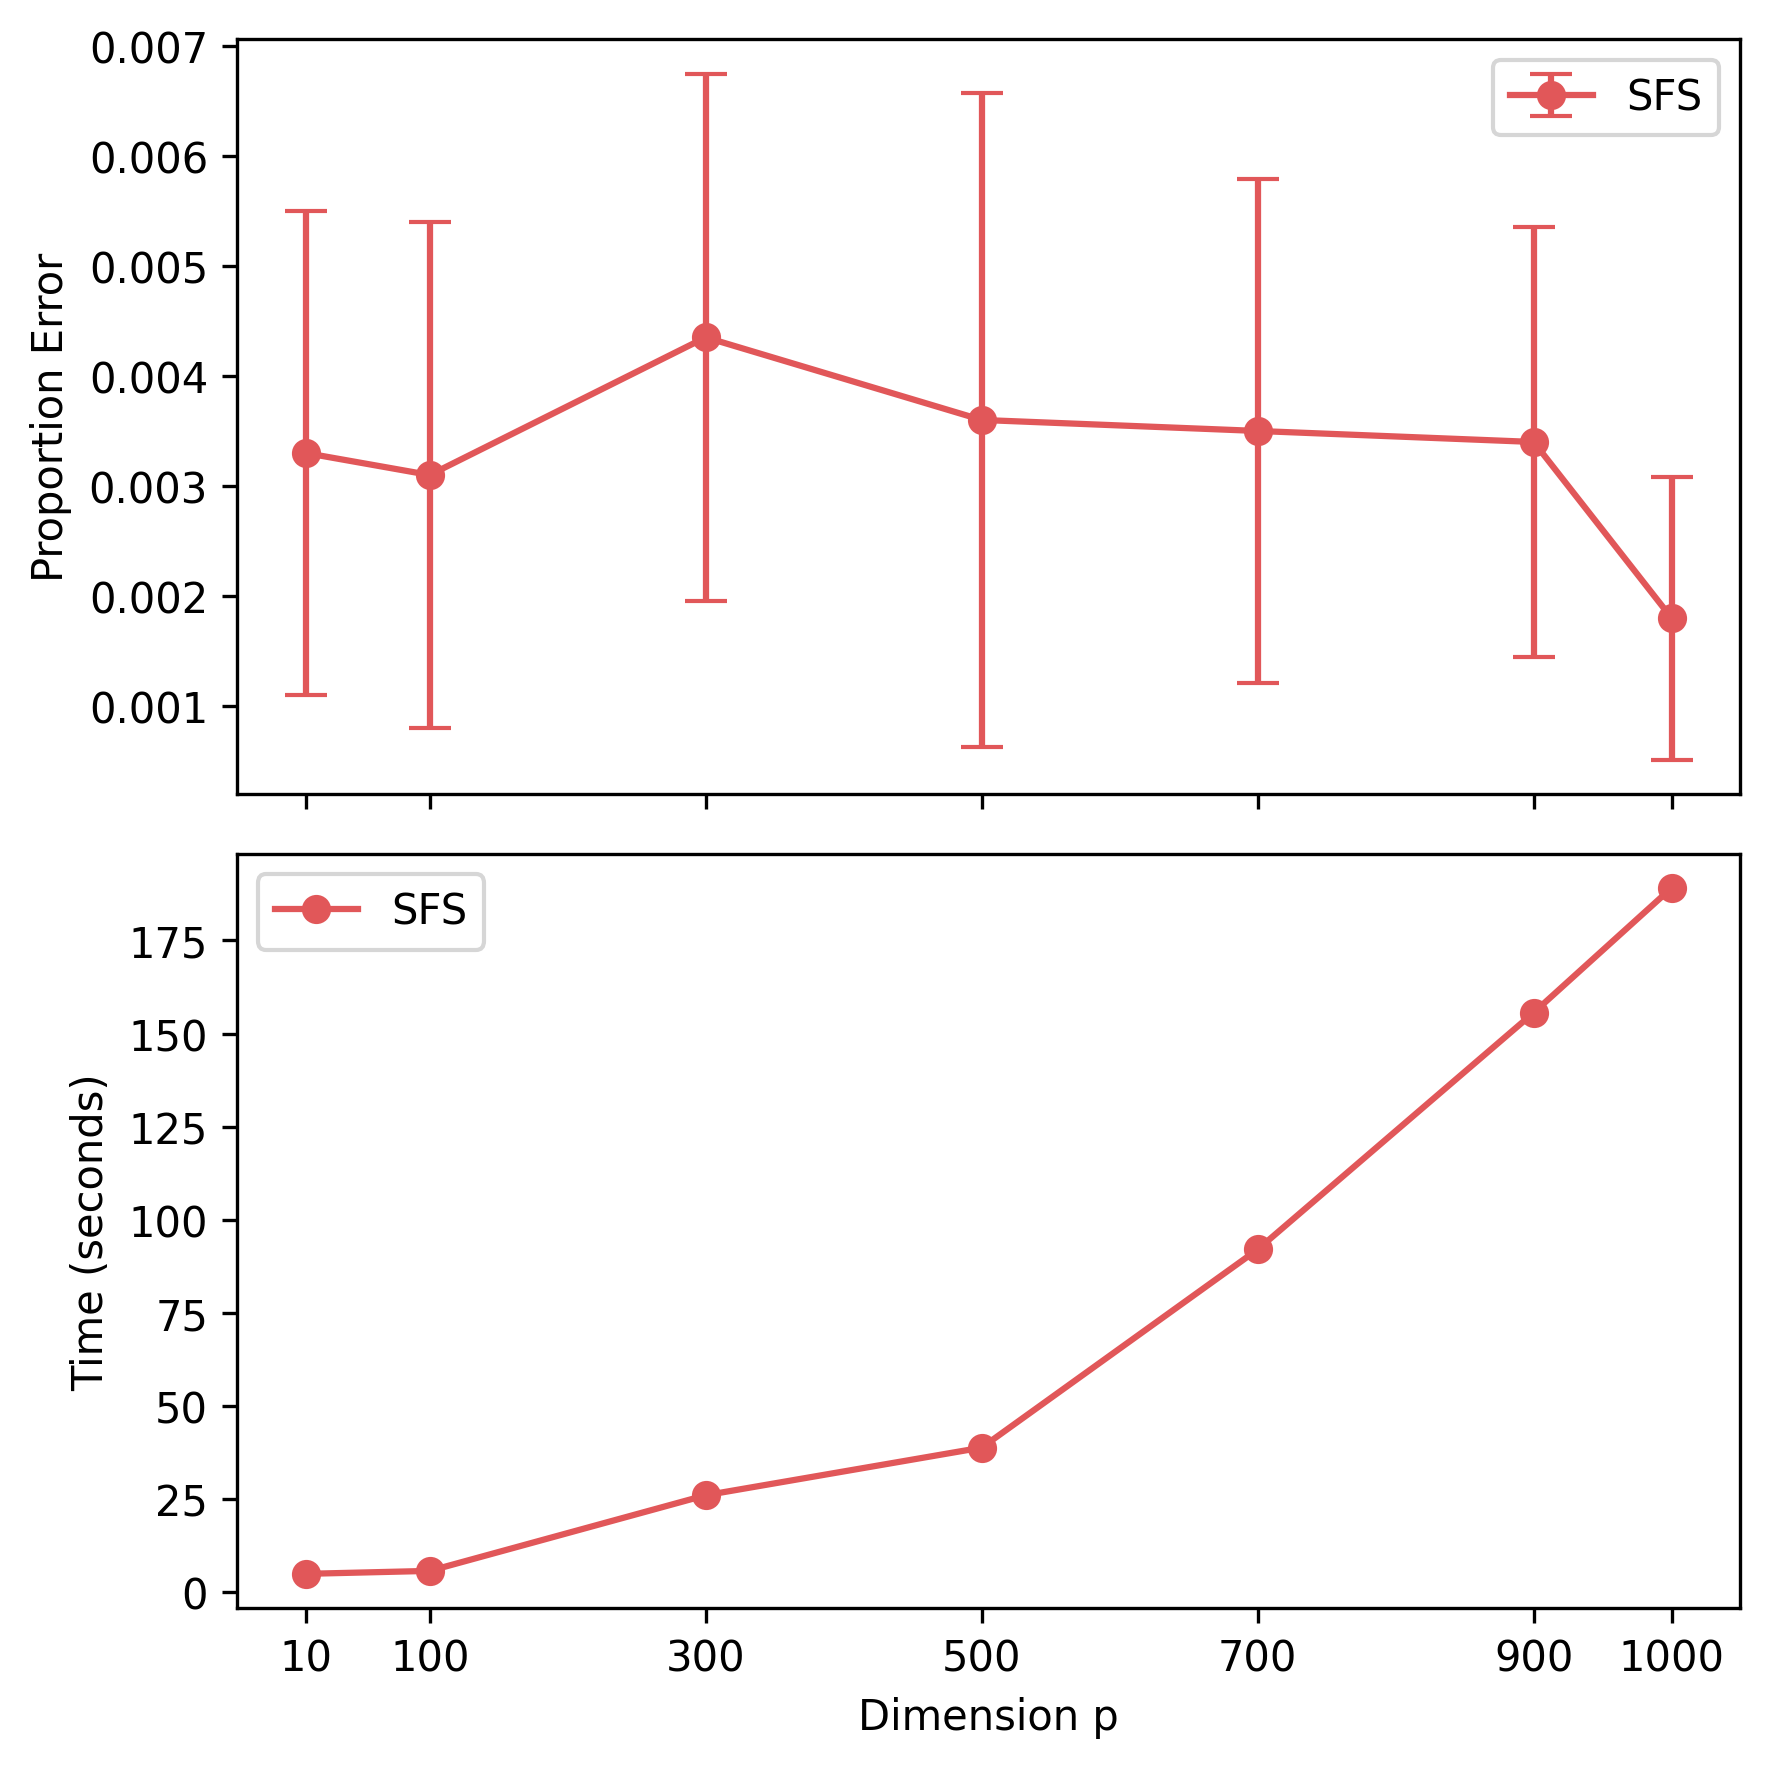

In [2]:
import matplotlib.pyplot as plt

# Compute the mean and standard deviation of errors
summary_df['Mean Error'] = summary_df['Proportion Error'].apply(lambda x: np.mean(x))
summary_df['Error Std'] = summary_df['Proportion Error'].apply(lambda x: np.std(x))


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), dpi=300, sharex=True)  # Shared x-axis and a taller figure to accommodate both plots

# Plot 1: Mean Proportion Error with Error Bars
ax1.errorbar(summary_df['Dimension p'], summary_df['Mean Error'], yerr=summary_df['Error Std'],
             marker='o', linestyle='-', capsize=5, color='#E15759', label='SFS')
ax1.set_ylabel('Proportion Error')
ax1.legend()  # Display the legend to show the label
# ax1.grid(True)

# Plot 2: Computation Time
ax2.plot(summary_df["Dimension p"], summary_df["Time (seconds)"],
         marker='o', linestyle='-', color='#E15759', label='SFS')
ax2.set_xlabel('Dimension p')
ax2.set_ylabel('Time (seconds)')
ax2.legend()  # Display the legend to show the label
# ax2.grid(True)

# Ensure all dimensions are labeled and adjust layout for no overlapping
plt.xticks(summary_df['Dimension p'])  # Apply x-axis ticks to both plots
plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()


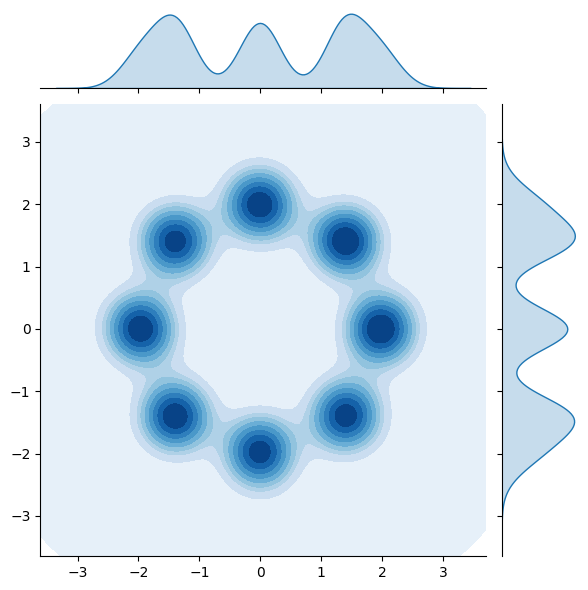

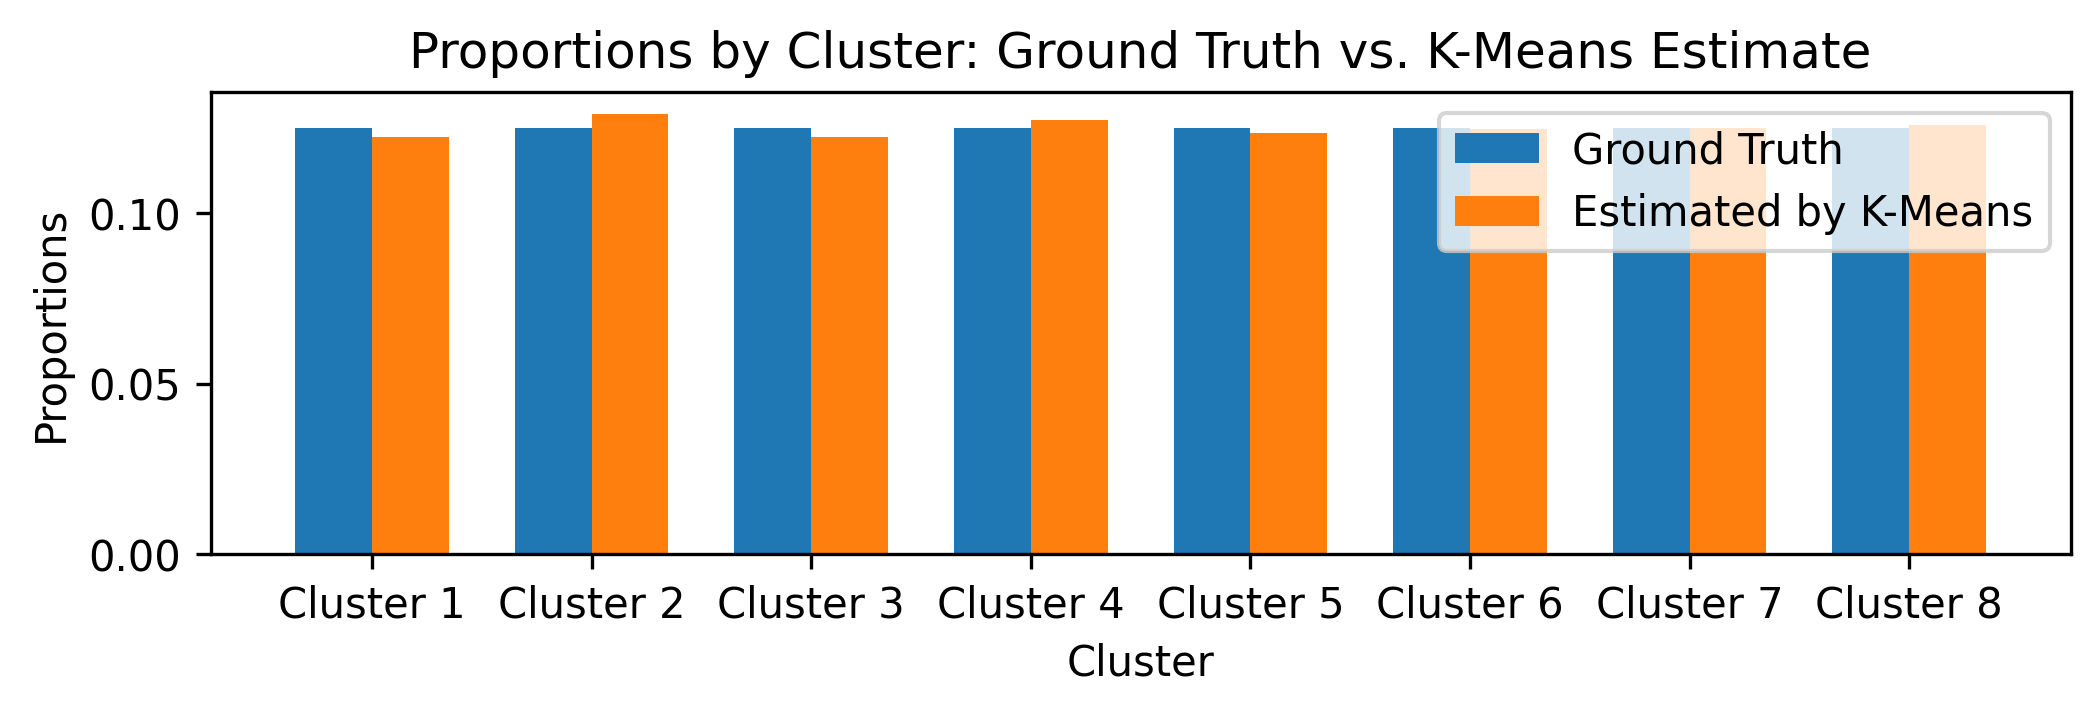

In [3]:
import seaborn as sns
h = sns.jointplot(x=res[0,:],y=res[1,:], kind='kde',fill=True, thresh=0, cmap='Blues')
kmeans_plot(res, theta)